In [ ]:
import sqlite3
import pandas as pd
import os
import glob

# --- 1. Configuration ---
csv_folder_path = r'./data' 
db_path = r'./esi_rankings.db'

# --- 2. Setup Database ---
conn = sqlite3.connect(db_path)
cursor = conn.cursor()
create_table_sql = """
CREATE TABLE IF NOT EXISTS esi_rankings (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    research_field TEXT NOT NULL,
    rank INTEGER,
    institution TEXT NOT NULL,
    country_region TEXT,
    documents INTEGER,
    cites INTEGER,
    cites_per_paper REAL,
    top_papers INTEGER
);
"""
cursor.execute(create_table_sql)
print(f"Database '{os.path.basename(db_path)}' and table 'esi_rankings' are ready.")

# --- 3. Process and Import CSV Files ---
csv_files = glob.glob(os.path.join(csv_folder_path, '*.csv'))

if not csv_files:
    print(f"WARNING: No CSV files found in '{csv_folder_path}'. Please check the path.")
else:
    for file_path in csv_files:
        print("-" * 50) 
        
        file_encoding = 'latin-1'
        with open(file_path, 'r', encoding=file_encoding) as f:
                first_line = f.readline()
        
        try:
            # Extract the research field from the first line's metadata
            field_value = first_line.split("Filter Value(s):")[1].split("Show:")[0].strip()
            print(f"Processing: {os.path.basename(file_path)} | Field: {field_value} | Encoding: {file_encoding}")

            # Read the CSV data using the correct encoding, skipping the metadata line
            df = pd.read_csv(file_path, header=1, encoding=file_encoding)

            # Rename columns to match our database schema
            df.rename(columns={
                'Unnamed: 0': 'rank',
                'Institutions': 'institution',
                'Countries/Regions': 'country_region',
                'Web of Science Documents': 'documents',
                'Cites': 'cites',
                'Cites/Paper': 'cites_per_paper',
                'Top Papers': 'top_papers'
            }, inplace=True)
            
            # --- THIS IS THE KEY FIX ---
            # Remove any rows where the 'institution' column is empty.
            # This will solve the "NOT NULL constraint failed" error.
            initial_rows = len(df)
            df.dropna(subset=['institution'], inplace=True)
            final_rows = len(df)
            
            if initial_rows > final_rows:
                print(f"INFO: Removed {initial_rows - final_rows} empty/invalid rows.")
            # ---------------------------

            # Add the research_field column to the DataFrame
            df['research_field'] = field_value
            
            # Select and reorder columns to be safe
            final_df = df[[
                'research_field', 'rank', 'institution', 'country_region',
                'documents', 'cites', 'cites_per_paper', 'top_papers'
            ]]

            # Append the cleaned data to the SQLite table
            final_df.to_sql('esi_rankings', conn, if_exists='append', index=False)
            print(f"SUCCESS: Imported {len(final_df)} records for '{field_value}'.")

        except Exception as e:
            print(f"ERROR: Could not process file {os.path.basename(file_path)}. Reason: {e}")

# --- 4. Finalize ---
conn.commit()
conn.close()
print("-" * 50)
print("All CSV files have been processed. The database is now complete.")

Database 'esi_rankings.db' and table 'esi_rankings' are ready.
--------------------------------------------------
Processing: PSYCHIATRY PSYCHOLOGY.csv | Field: PSYCHIATRY/PSYCHOLOGY | Encoding: latin-1
INFO: Removed 1 empty/invalid rows.
SUCCESS: Imported 1147 records for 'PSYCHIATRY/PSYCHOLOGY'.
--------------------------------------------------
Processing: IMMUNOLOGY.csv | Field: IMMUNOLOGY | Encoding: latin-1
INFO: Removed 1 empty/invalid rows.
SUCCESS: Imported 1177 records for 'IMMUNOLOGY'.
--------------------------------------------------
Processing: ENGINEERING.csv | Field: ENGINEERING | Encoding: latin-1
INFO: Removed 1 empty/invalid rows.
SUCCESS: Imported 2787 records for 'ENGINEERING'.
--------------------------------------------------
Processing: GEOSCIENCES.csv | Field: GEOSCIENCES | Encoding: latin-1
INFO: Removed 1 empty/invalid rows.
SUCCESS: Imported 1175 records for 'GEOSCIENCES'.
--------------------------------------------------
Processing: MATERIALS SCIENCE.csv |

In [47]:
def get_rankings_by_institution(db_path, institution_name):
    """
    Queries the database for the rankings of a specific institution.
    This version correctly selects 3 columns to avoid unpacking errors.
    """
    try:
        with sqlite3.connect(db_path) as conn:
            cursor = conn.cursor()
            # This query now correctly selects 3 columns:
            query = """
                SELECT research_field, rank, institution
                FROM esi_rankings 
                WHERE institution LIKE ? 
                ORDER BY research_field;
            """
            search_term = f'%{institution_name}%'
            cursor.execute(query, (search_term,))
            results = cursor.fetchall()
            return results
    except Exception as e:
        print(f"An error occurred while querying for {institution_name}: {e}")
        return []
    
ECNU = "EAST CHINA NORMAL UNIV"
ecnu_ranking = get_rankings_by_institution(db_path, ECNU)

for (fd, rk, _) in ecnu_ranking:
    print("{:<30}{:<50}".format(fd,rk))

AGRICULTURAL SCIENCES         845                                               
BIOLOGY & BIOCHEMISTRY        721                                               
CHEMISTRY                     90                                                
CLINICAL MEDICINE             2852                                              
COMPUTER SCIENCE              207                                               
ENGINEERING                   317                                               
ENVIRONMENT/ECOLOGY           130                                               
GEOSCIENCES                   275                                               
MATERIALS SCIENCE             196                                               
MATHEMATICS                   115                                               
MOLECULAR BIOLOGY & GENETICS  867                                               
NEUROSCIENCE & BEHAVIOR       853                                               
PHARMACOLOGY & TOXICOLOGY   

--- Starting Data Collection ---
Querying rankings for: EAST CHINA NORMAL UNIV...
Querying rankings for: PEKING UNIV...
Querying rankings for: TSINGHUA UNIV...
Querying rankings for: FUDAN UNIV...
Querying rankings for: SHANGHAI JIAO TONG UNIV...
Querying rankings for: TONGJI UNIV...

--- Data Collection Complete ---
Sample of the collected data:
              institution          research_field  rank
0  EAST CHINA NORMAL UNIV   AGRICULTURAL SCIENCES   845
1  EAST CHINA NORMAL UNIV  BIOLOGY & BIOCHEMISTRY   721
2  EAST CHINA NORMAL UNIV               CHEMISTRY    90
3  EAST CHINA NORMAL UNIV       CLINICAL MEDICINE  2852
4  EAST CHINA NORMAL UNIV        COMPUTER SCIENCE   207

--- Generating Visualization ---


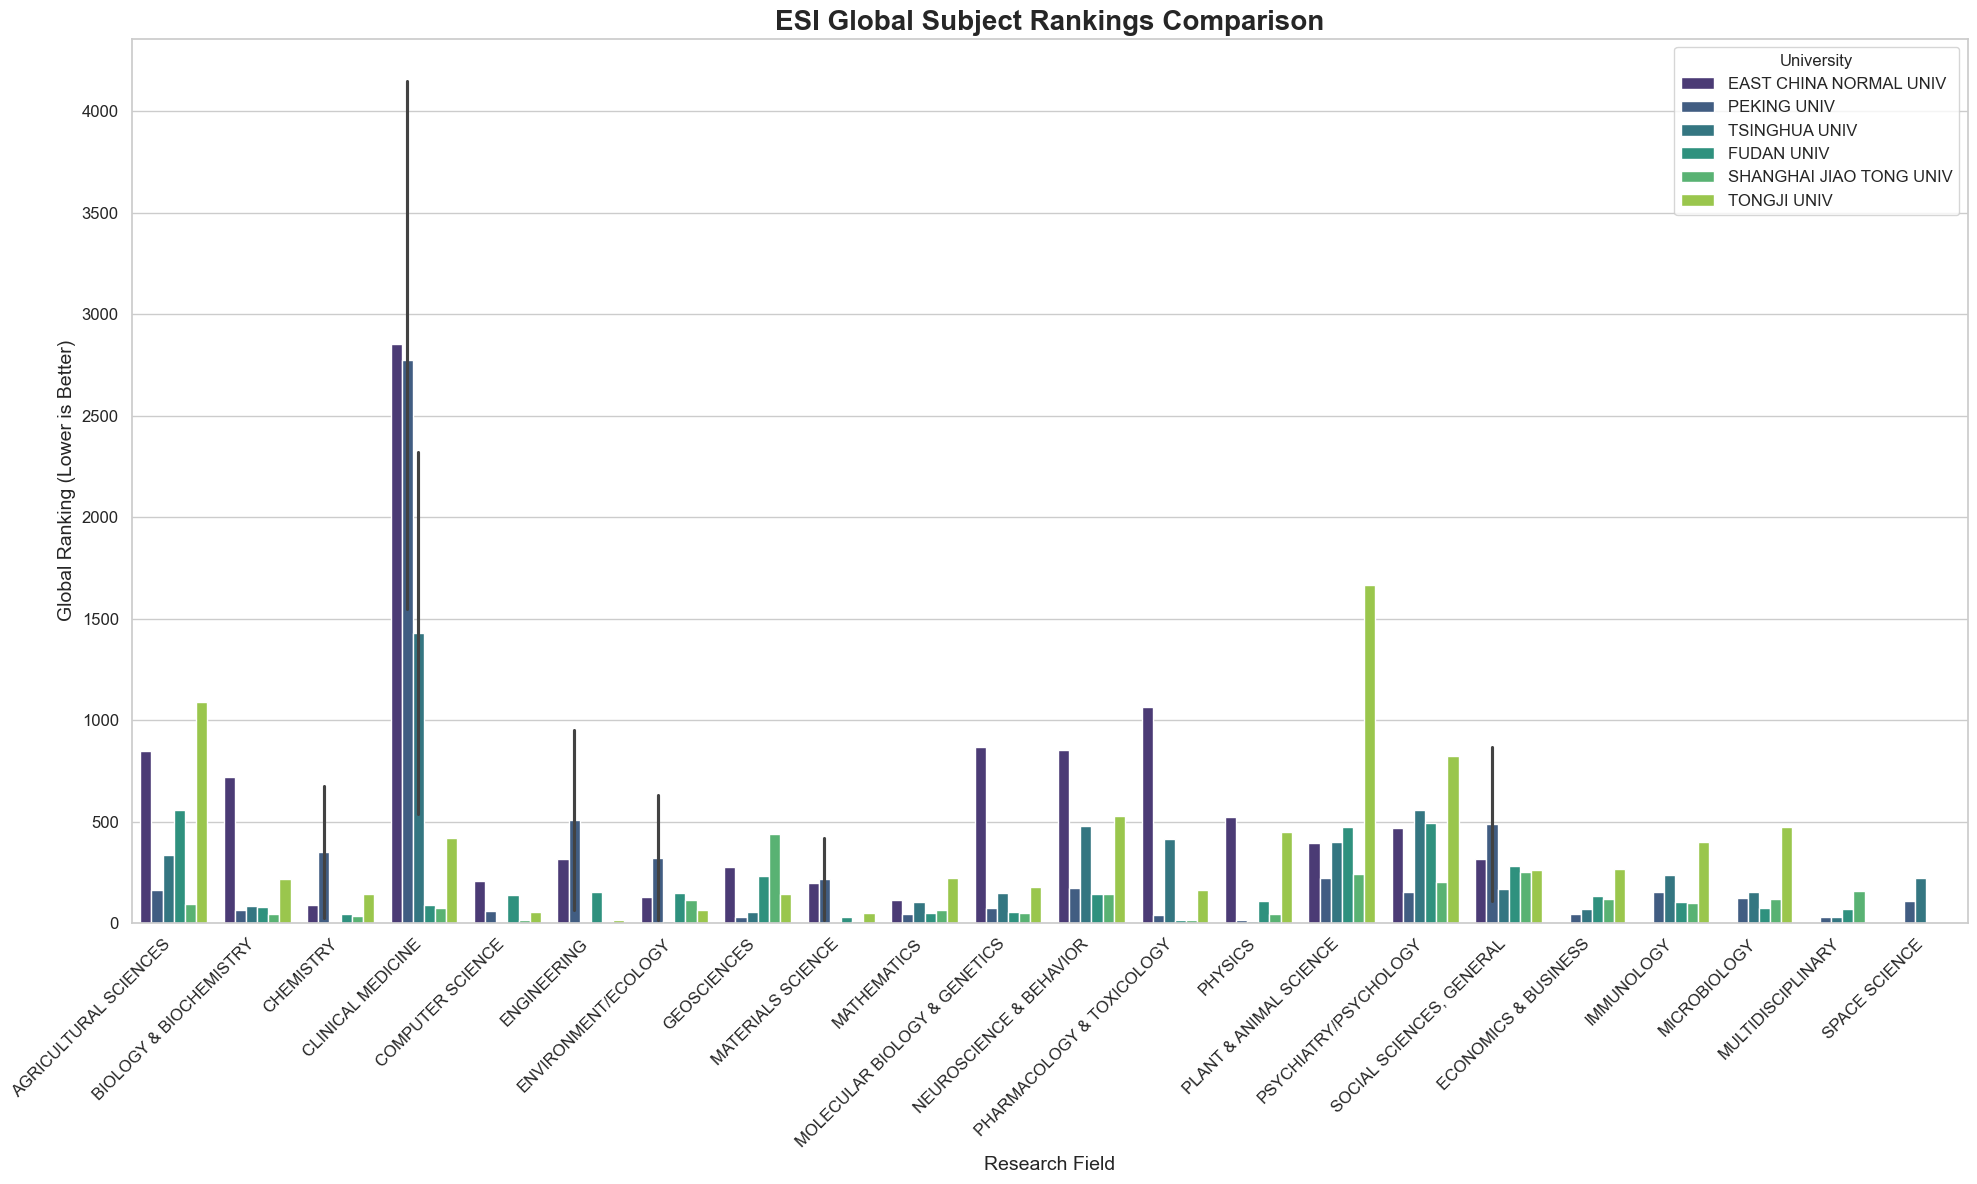

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

universities_to_compare = [
    "EAST CHINA NORMAL UNIV",
    "PEKING UNIV",
    "TSINGHUA UNIV",
    "FUDAN UNIV",
    "SHANGHAI JIAO TONG UNIV",
    "TONGJI UNIV"
]

# 2. Collect Data
all_rankings_data = []
print("--- Starting Data Collection ---")

for university in universities_to_compare:
    print(f"Querying rankings for: {university}...")
    rankings = get_rankings_by_institution(db_path, university)
    
    # print(rankings)
    
    for field, rank, full_name in rankings:
        all_rankings_data.append({
            'institution': university,
            'research_field': field, 
            'rank': rank
        })

if not all_rankings_data:
    print("\nNo data found. Please check university names and database path.")
else:
    print("\n--- Data Collection Complete ---")
    
    df = pd.DataFrame(all_rankings_data)
    print("Sample of the collected data:")
    print(df.head())

    print("\n--- Generating Visualization ---")
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(20, 12))

    barplot = sns.barplot(
        data=df, 
        x='research_field', 
        y='rank', 
        hue='institution',
        palette='viridis'
    )

    plt.title('ESI Global Subject Rankings Comparison', fontsize=20, weight='bold')
    plt.xlabel('Research Field', fontsize=14)
    plt.ylabel('Global Ranking (Lower is Better)', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='University', fontsize=12)
    plt.tight_layout()

    plt.show()

In [ ]:
def execute_query(db_path, query):
    """
    Executes a SQL query on the specified database and returns the result as a pandas DataFrame.

    Args:
        db_path (str): The path to the SQLite database file.
        query (str): The SQL query string to execute.

    Returns:
        pandas.DataFrame: A DataFrame containing the query results, or None if an error occurs.
    """
    try:
        with sqlite3.connect(db_path) as conn:
            # Use pandas to directly read the SQL query results into a DataFrame
            df = pd.read_sql_query(query, conn)
            return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# --- Main execution block ---
if __name__ == "__main__":
    database_file = 'esi_rankings.db'

    # --- Analysis 1: Collective Strength ---
    print("--- Analysis 1: Number of Top 100 Mainland Chinese Universities by Subject ---")
    query1 = """
        SELECT
          research_field,
          COUNT(institution) AS number_of_top_100_institutions
        FROM
          esi_rankings
        WHERE
          country_region = 'CHINA MAINLAND' AND rank <= 100
        GROUP BY
          research_field
        ORDER BY
          number_of_top_100_institutions DESC;
    """
    china_strength_df = execute_query(database_file, query1)
    if china_strength_df is not None:
        print(china_strength_df)

    print("\n" + "="*80 + "\n")

    # --- Analysis 2: Peak Performance ---
    print("--- Analysis 2: Top-Ranked Mainland Chinese University in Each Subject ---")
    query2 = """
        SELECT
          research_field,
          institution,
          rank
        FROM
          (
            SELECT
              research_field,
              institution,
              rank,
              ROW_NUMBER() OVER(PARTITION BY research_field ORDER BY rank ASC) as rn
            FROM
              esi_rankings
            WHERE
              country_region = 'CHINA MAINLAND'
          )
        WHERE
          rn = 1
        ORDER BY
          research_field;
    """
    china_leaders_df = execute_query(database_file, query2)
    if china_leaders_df is not None:
        print(china_leaders_df)

--- Analysis 1: Number of Top 100 Mainland Chinese Universities by Subject ---
                  research_field  number_of_top_100_institutions
0              MATERIALS SCIENCE                              48
1                    ENGINEERING                              46
2                      CHEMISTRY                              46
3               COMPUTER SCIENCE                              44
4      PHARMACOLOGY & TOXICOLOGY                              29
5                    MATHEMATICS                              24
6                    GEOSCIENCES                              22
7          AGRICULTURAL SCIENCES                              22
8            ENVIRONMENT/ECOLOGY                              14
9         PLANT & ANIMAL SCIENCE                              13
10                  MICROBIOLOGY                              11
11                       PHYSICS                              10
12  MOLECULAR BIOLOGY & GENETICS                               9
13         

In [49]:
import sqlite3
import pandas as pd

def execute_query(db_path, query):
    """
    Executes a SQL query and returns the result as a pandas DataFrame.
    """
    try:
        with sqlite3.connect(db_path) as conn:
            df = pd.read_sql_query(query, conn)
            return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# --- Main execution block ---
if __name__ == "__main__":
    database_file = 'esi_rankings.db'

    # --- Analysis 1: Global Research Powerhouses ---
    print("--- Analysis 1: Top 20 Global Regions by Total Citations ---")
    query1 = """
        SELECT
          country_region,
          SUM(cites) AS total_cites,
          SUM(documents) AS total_documents,
          COUNT(DISTINCT institution) AS number_of_ranked_institutions
        FROM
          esi_rankings
        GROUP BY
          country_region
        ORDER BY
          total_cites DESC
        LIMIT 20;
    """
    powerhouses_df = execute_query(database_file, query1)
    if powerhouses_df is not None:
        # Improve formatting for large numbers
        powerhouses_df['total_cites'] = powerhouses_df['total_cites'].map('{:,.0f}'.format)
        powerhouses_df['total_documents'] = powerhouses_df['total_documents'].map('{:,.0f}'.format)
        print(powerhouses_df)

    print("\n" + "="*80 + "\n")

    # --- Analysis 2: Concentration of Elite Institutions ---
    print("--- Analysis 2: Top 20 Global Regions by Number of Top 100 Placements ---")
    query2 = """
        SELECT
          country_region,
          COUNT(institution) as top_100_placements
        FROM
          esi_rankings
        WHERE
          rank <= 100
        GROUP BY
          country_region
        ORDER BY
          top_100_placements DESC
        LIMIT 20;
    """
    elites_df = execute_query(database_file, query2)
    if elites_df is not None:
        print(elites_df)

--- Analysis 1: Top 20 Global Regions by Total Citations ---
           country_region  total_cites total_documents  \
0                     USA  381,717,908      12,371,999   
1          CHINA MAINLAND  176,456,031       8,733,347   
2                  FRANCE   77,303,271       2,929,096   
3                 ENGLAND   68,990,134       2,143,125   
4   GERMANY (FED REP GER)   61,468,719       2,177,835   
5                    None   45,485,242       1,125,071   
6               AUSTRALIA   42,097,824       1,438,061   
7                   ITALY   39,164,264       1,553,112   
8                  CANADA   35,448,075       1,286,132   
9                   SPAIN   34,822,971       1,345,845   
10            NETHERLANDS   27,493,752         872,532   
11                  JAPAN   24,332,856       1,196,491   
12                  INDIA   21,847,724       1,159,346   
13            SOUTH KOREA   21,837,617       1,098,624   
14            SWITZERLAND   20,409,726         622,925   
15         

In [55]:
import sqlite3
import pandas as pd
import plotly.graph_objects as go
import pycountry
import numpy as np

def execute_query(db_path, query):
    """Executes a SQL query and returns the result as a pandas DataFrame."""
    try:
        with sqlite3.connect(db_path) as conn:
            df = pd.read_sql_query(query, conn)
            return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def get_iso_alpha_3(country_name):
    """Converts a country name to its ISO 3166-1 alpha-3 code."""
    manual_map = {
        'CHINA MAINLAND': 'CHN', 'USA': 'USA', 'ENGLAND': 'GBR',
        'SCOTLAND': 'GBR', 'WALES': 'GBR', 'NORTH IRELAND': 'GBR',
        'GERMANY (FED REP GER)': 'DEU', 'SOUTH KOREA': 'KOR',
        'RUSSIA': 'RUS', 'IRAN': 'IRN'
    }
    if country_name in manual_map:
        return manual_map[country_name]
    try:
        return pycountry.countries.search_fuzzy(country_name)[0].alpha_3
    except (LookupError, AttributeError):
        return None

# --- 1. Fetch Granular Data by Subject ---
database_file = 'esi_rankings.db'
print("--- Step 1: Fetching detailed data by subject from database ---")

# This query gets the citation data for each country IN EACH subject, without aggregating yet
subject_data_query = """
    SELECT
      country_region,
      research_field,
      SUM(cites) AS total_cites -- Sum cites for all institutions in a country for a given field
    FROM
      esi_rankings
    GROUP BY
      country_region, research_field;
"""
df = execute_query(database_file, subject_data_query)

if df is not None:
    print(f"Successfully fetched {len(df)} records across all subjects.")

    # --- 2. Clean and Prepare Data ---
    print("\n--- Step 2: Cleaning data and mapping to ISO codes ---")
    df.dropna(subset=['country_region', 'research_field'], inplace=True)
    df['total_cites'] = pd.to_numeric(df['total_cites'], errors='coerce').fillna(0)
    df['iso_alpha'] = df['country_region'].apply(get_iso_alpha_3)
    
    # Get a sorted list of unique subjects for the dropdown menu
    subjects = sorted(df['research_field'].unique())
    print(f"Found {len(subjects)} unique subjects.")

    # --- 3. Create the Interactive Visualization ---
    print("\n--- Step 3: Building interactive map with dropdown menu ---")
    fig = go.Figure()

    # Create one map layer (trace) for each subject
    for subject in subjects:
        # Filter the dataframe for the current subject
        subject_df = df[df['research_field'] == subject]
        
        # Calculate the log of citations for the color scale
        log_cites = np.log10(subject_df['total_cites'] + 1)

        fig.add_trace(
            go.Choropleth(
                locations=subject_df['iso_alpha'],
                z=log_cites, # The value that determines the color
                text=subject_df['country_region'], # Text that appears on hover
                customdata=subject_df['total_cites'], # Pass original cites for hover text
                hovertemplate='<b>%{text}</b><br>Total Cites: %{customdata:,.0f}<extra></extra>',
                colorscale='Plasma',
                name=subject, # Name for the trace
                visible=(subject == subjects[0]) # Make only the first subject visible initially
            )
        )

    # --- 4. Create the Dropdown Menu ---
    buttons = []
    for i, subject in enumerate(subjects):
        # Create a visibility mask. True for the current subject, False for all others.
        visibility_mask = [False] * len(subjects)
        visibility_mask[i] = True
        
        buttons.append(
            dict(
                label=subject,
                method='update',
                args=[{'visible': visibility_mask}]
            )
        )

    # Update the layout of the figure with the dropdown menu and title
    fig.update_layout(
        title_text=f'<b>Global Research Impact by Subject</b><br><i>Select a subject from the dropdown menu</i>',
        title_font_size=22,
        updatemenus=[
            dict(
                active=0,
                buttons=buttons,
                direction="down",
                pad={"r": 50, "t": 50},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.15,
                yanchor="top"
            )
        ],
        geo=dict(
            showframe=False,
            showcoastlines=False,
            projection_type='natural earth'
        )
    )

    fig.show()

else:
    print("Failed to fetch data from the database.")

--- Step 1: Fetching detailed data by subject from database ---
Successfully fetched 1558 records across all subjects.

--- Step 2: Cleaning data and mapping to ISO codes ---
Found 22 unique subjects.

--- Step 3: Building interactive map with dropdown menu ---
